In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
np.random.seed(42)
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

In [20]:
df = pd.read_csv('train.csv').rename(columns={'Unnamed: 0':'id'}) # для исходной колонки с id создаю отдельную колонку id
df['period_start_dt'] = pd.to_datetime(df['period_start_dt']) # перевожу временные признаки в нужный формат, чтобы распарсить

In [21]:
# посмотрим процентное содержание отсутствующих значений
df.isna().sum() / (df.count() + df.isna().sum()) * 100

id                   0.000000
product_rk           0.000000
store_location_rk    0.000000
period_start_dt      0.000000
demand               3.395201
PROMO1_FLAG          0.523427
PROMO2_FLAG          0.523427
PRICE_REGULAR        3.188660
PRICE_AFTER_DISC     3.202807
NUM_CONSULTANT       0.523427
AUTORIZATION_FLAG    0.523427
dtype: float64

In [22]:
# в категориальных признаках заменяю отсутствующее значение на медиану, в интервальных на среднее
# добавляем бинарный признак, являлось ли значение в соответствующей колонке nan

nans_cat = ['PROMO1_FLAG', 'PROMO2_FLAG', 'AUTORIZATION_FLAG']
nans_num = ['PRICE_REGULAR', 'PRICE_AFTER_DISC', 'NUM_CONSULTANT']
for feat in nans_cat:
    df[feat + '_isnan'] = 0
    df.loc[df[feat].isna(), feat + '_isnan'] = 1 
    df[feat].fillna(value=df[feat].median(), inplace=True)
for feat in nans_num:
    df[feat + '_isnan'] = 0
    df.loc[df[feat].isna(), feat + '_isnan'] = 1 
    df[feat].fillna(value=df[feat].mean(), inplace=True)

In [23]:
# объединяю обучающую выборку с информацией о магазинах
X_train = df
stores = pd.read_csv('STORE_LOCATION.csv', sep=';').rename(columns=str.lower) # меняю на нижний регистр для удобства

In [24]:
stores['store_open_dttm'] = pd.to_datetime(stores['store_open_dttm'], format='%d%b%Y:%H:%M:%S') # перевожу в нужный формат

In [25]:
X_train = pd.merge(X_train, stores, on='store_location_rk')
X_test = X_train[df.demand.isna()].drop(columns='demand')
X_train = X_train[X_train.demand.notna()]
y = X_train.demand

In [26]:
# создаю новые признаки, разделяя дату и время по частям: год, месяц, номер недели в году, день в году
# время открытия и закрытия магазинов

X_train['Month'] = X_train['period_start_dt'].dt.month
X_train['Day'] = X_train['period_start_dt'].dt.dayofyear
X_train['Week'] = X_train['period_start_dt'].dt.week
X_train['Year'] = X_train['period_start_dt'].dt.year
X_train.drop(columns='period_start_dt', inplace=True)

X_train['Year_open'] = X_train['store_open_dttm'].dt.year
X_train['Month_open'] = X_train['store_open_dttm'].dt.month
X_train['Day_open'] = X_train['store_open_dttm'].dt.dayofyear
X_train['Hour_open'] = X_train['store_open_dttm'].dt.hour
X_train['Time_open'] = X_train['store_open_dttm'].dt.hour * 60 * 60 + X_train['store_open_dttm'].dt.minute * 60 + \
    X_train['store_open_dttm'].dt.second
X_train.drop(columns='store_open_dttm', inplace=True)


X_test['Month'] = X_test['period_start_dt'].dt.month
X_test['Day'] = X_test['period_start_dt'].dt.dayofyear
X_test['Week'] = X_test['period_start_dt'].dt.week
X_test['Year'] = X_test['period_start_dt'].dt.year
X_test.drop(columns='period_start_dt', inplace=True)

X_test['Year_open'] = X_test['store_open_dttm'].dt.year
X_test['Month_open'] = X_test['store_open_dttm'].dt.month
X_test['Day_open'] = X_test['store_open_dttm'].dt.dayofyear
X_test['Hour_open'] = X_test['store_open_dttm'].dt.hour
X_test['Time_open'] = X_test['store_open_dttm'].dt.hour * 60 * 60 + X_test['store_open_dttm'].dt.minute * 60 + \
    X_test['store_open_dttm'].dt.second
X_test.drop(columns='store_open_dttm', inplace=True)

In [17]:
X_train.drop(columns=[*X_train.loc[:, X_train.isna().sum(axis=0) / X_train.shape[0] * 100 >= 80].columns.to_list()], 
                      inplace=True)

In [31]:
print(*X_train.loc[:, X_train.isna().sum(axis=0) / X_train.shape[0] * 100 >= 80].columns.to_list())

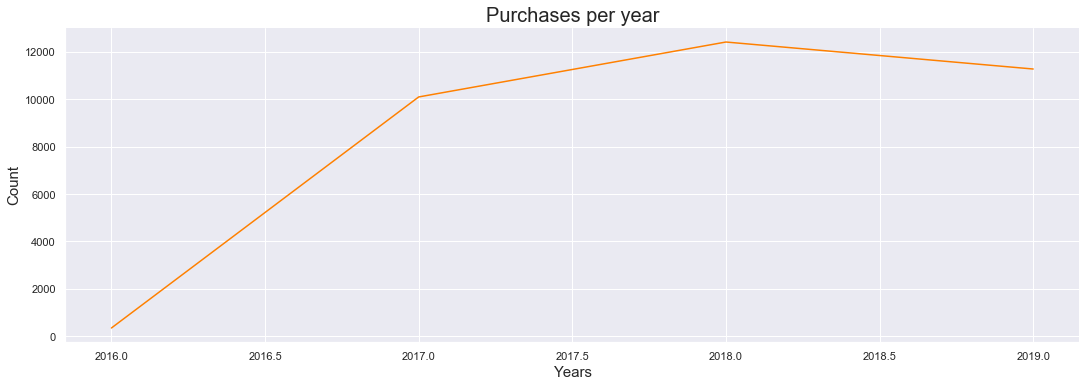

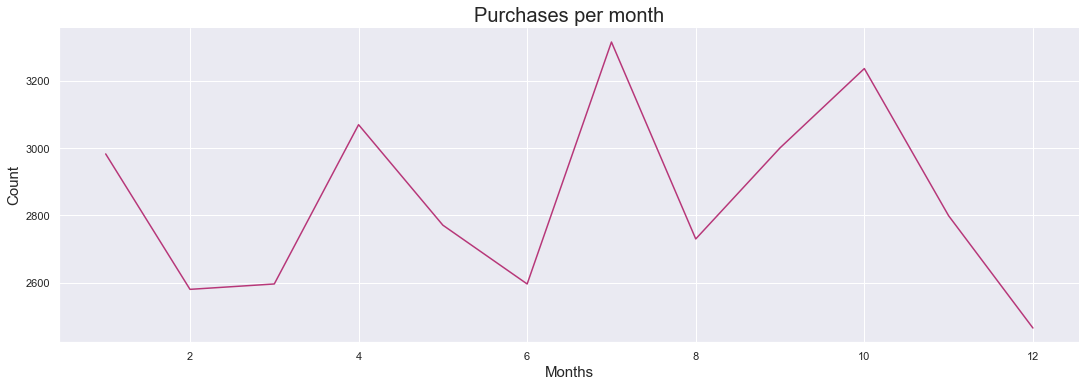

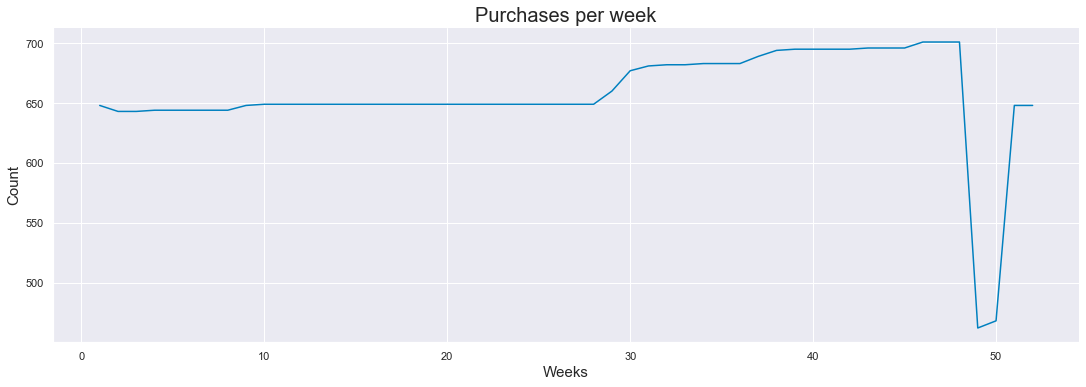

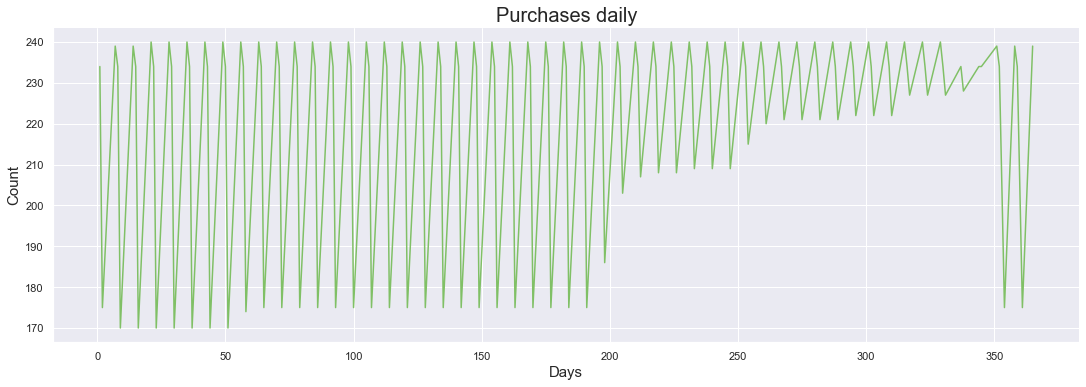

In [9]:
# нарисуем графики числа покупок в зависимости от созданных параметров времени
# заметим, что новые признаки являются полезными, так как количество в них далеко не константо, различается в зависимости от 
# значения, поэтому модель отсюда сможет найти какие-либо зависимости

y_cnt = X_train.groupby(X_train['Year'], as_index=True).count()['id']
yr = y_cnt.to_frame()
sns.relplot(data=yr, kind='line', palette='autumn', legend=False, aspect=3)
plt.title("Purchases per year", fontsize = 20)
plt.xlabel('Years', fontsize = 15)
plt.ylabel('Сount', fontsize = 15)
plt.show()

m_cnt = X_train.groupby(X_train['Month'], as_index=True).count()['id']
m = m_cnt.to_frame()
sns.relplot(data=m, kind='line', palette='magma', legend=False, aspect=3)
plt.title("Purchases per month", fontsize = 20)
plt.xlabel('Months', fontsize = 15)
plt.ylabel('Сount', fontsize = 15)
plt.show()

w_cnt = X_train.groupby(X_train['Week'], as_index=True).count()['id']
w = w_cnt.to_frame()
sns.relplot(data=w, kind='line', palette='winter', legend=False, aspect=3)
plt.title("Purchases per week", fontsize = 20)
plt.xlabel('Weeks', fontsize = 15)
plt.ylabel('Сount', fontsize = 15)
plt.show()

d_cnt = X_train.groupby(X_train['Day'], as_index=True).count()['id']
d = d_cnt.to_frame()
sns.relplot(data=d, kind='line', palette='summer', legend=False, aspect=3)
plt.title("Purchases daily", fontsize = 20)
plt.xlabel('Days', fontsize = 15)
plt.ylabel('Сount', fontsize = 15)
plt.show()

In [10]:
# разделяю признаки на категориальные и числовые

categorical = ['PROMO1_FLAG', 'PROMO2_FLAG', 'product_rk', 'AUTORIZATION_FLAG', 'store_location_lvl_rk4', 
               'store_location_lvl_rk3', 'store_location_lvl_rk2', 'store_location_lvl_rk1', 'store_closure_dttm', 
               'store_location_adk_hashing', 'store_location_attrib1_hashing', 'store_location_attrib2_hashing',
               'store_location_attrib3_hashing', 'store_location_attrib4_hashing', 'store_location_attrib5_hashing', 
               'store_location_attrib6_hashing', 'store_location_attrib7_hashing', 'store_location_attrib8_hashing',
               'store_location_attrib9_hashing', 'store_location_attrib10_hashing', 'store_location_attrib11_hashing', 
               'store_location_attrib12_hashing', 'store_location_attrib13_hashing', 'store_location_attrib14_hashing',
               'store_location_attrib15_hashing', 'store_location_attrib16_hashing', 'store_location_attrib17_hashing',
               'store_location_attrib18_hashing', 'store_location_attrib19_hashing', 'store_location_attrib20_hashing',
               'store_location_attrib21_hashing', 'PROMO1_FLAG_isnan', 'PROMO2_FLAG_isnan', 'AUTORIZATION_FLAG_isnan', 
               'PRICE_REGULAR_isnan', 'PRICE_AFTER_DISC_isnan', 'NUM_CONSULTANT_isnan']

numeric_features = ['PRICE_REGULAR', 'PRICE_AFTER_DISC', 'NUM_CONSULTANT', 'Day', 'Day_open', 'Hour_open', 'Time_open',
                   'Month','Week', 'Year', 'Year_open', 'Month_open']

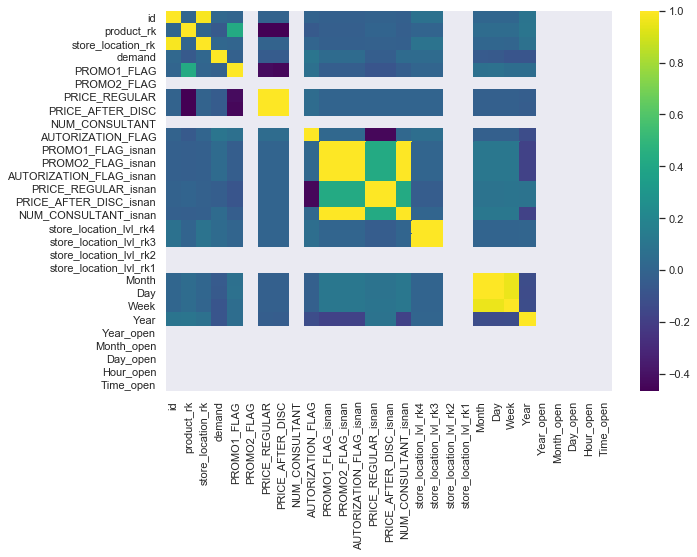

In [11]:
# посмотрим на корреляцию между получившимися признаками и таргетом
# серые значения -- признаки с уникальным значением, в процессе решения я пробовала их удалять, но, как ни странно, качество 
# ухудшалось
# уже здесь видно, что новые бинарные признаки влияют на таргет, как и значения флагов

plt.figure(figsize=(10, 7))
c = X_train.corr()
sns.heatmap(c,cmap="viridis")
plt.show()

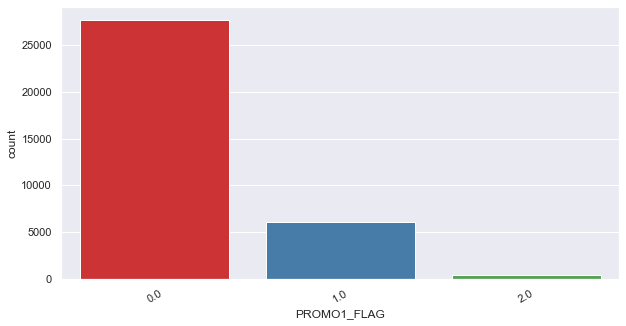

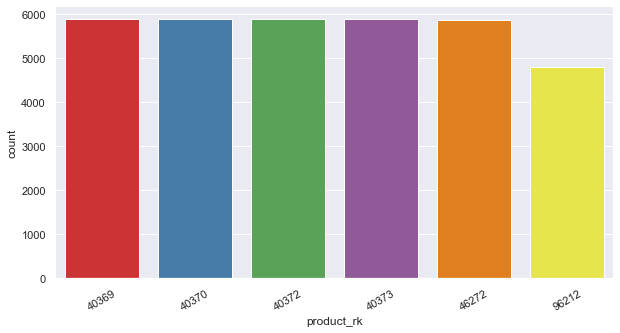

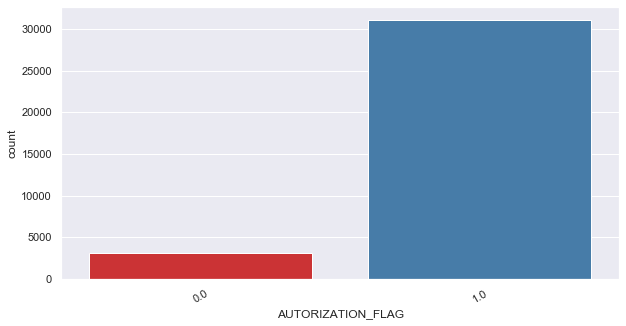

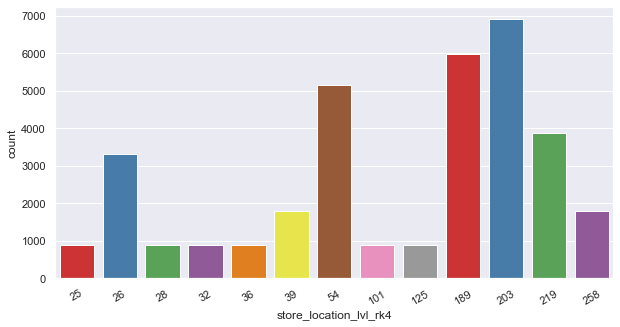

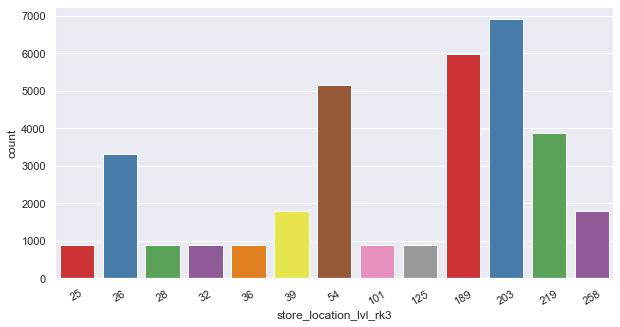

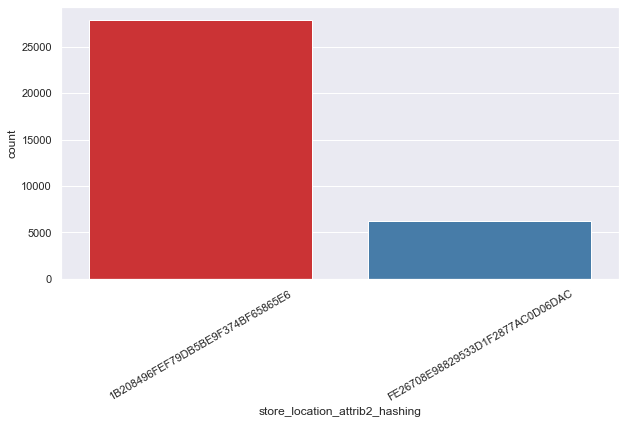

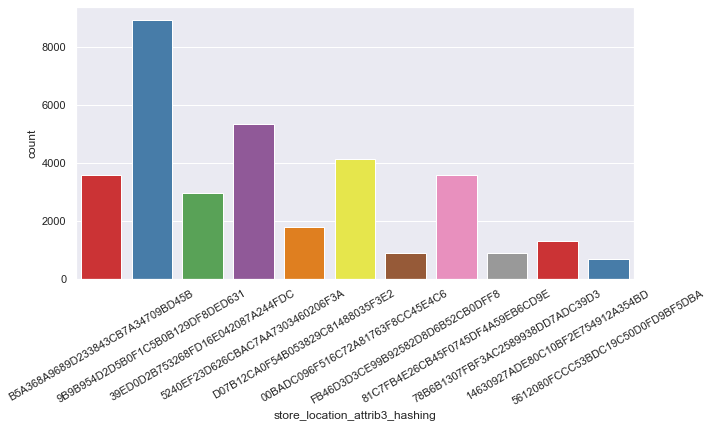

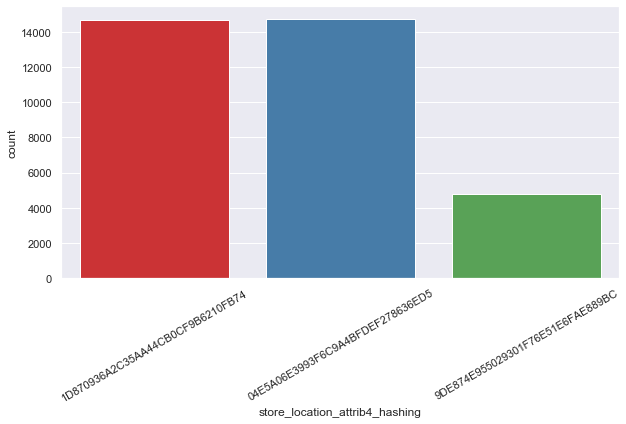

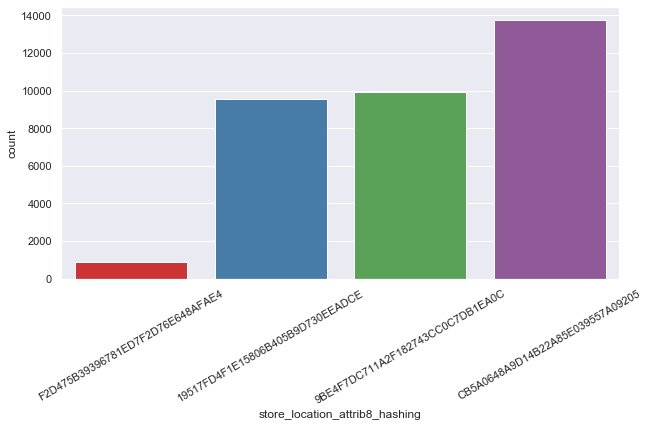

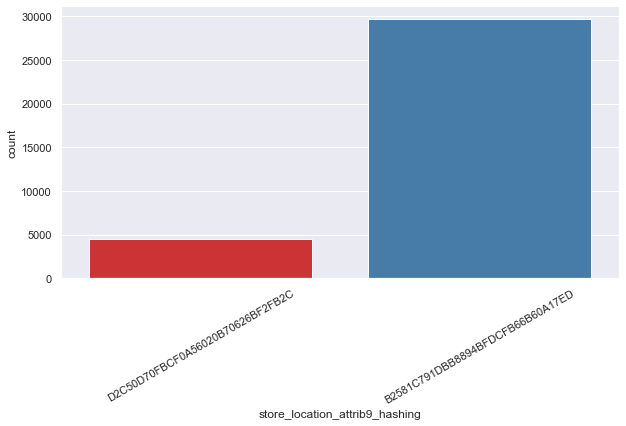

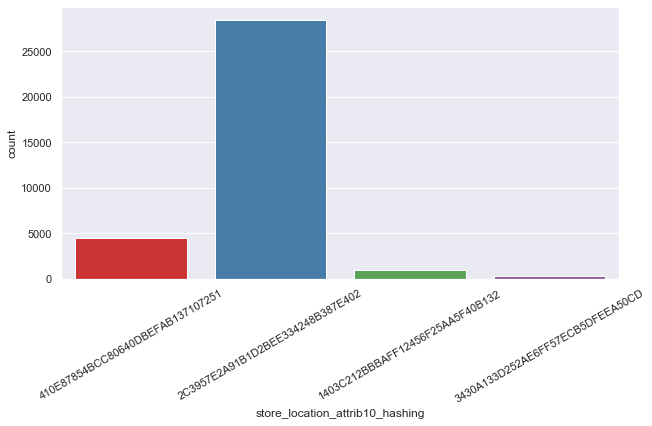

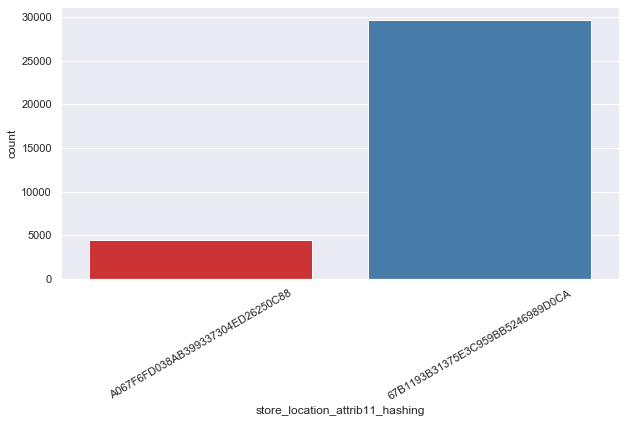

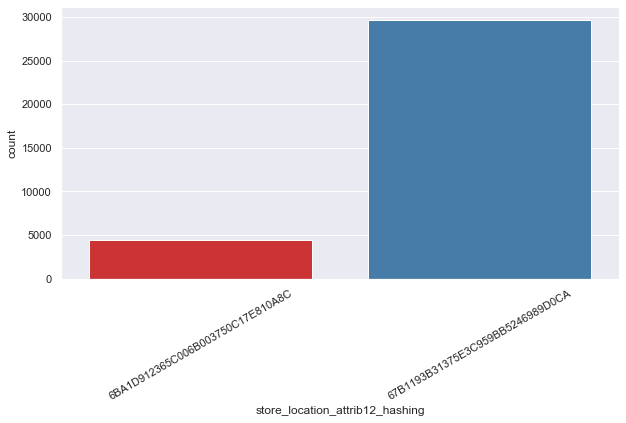

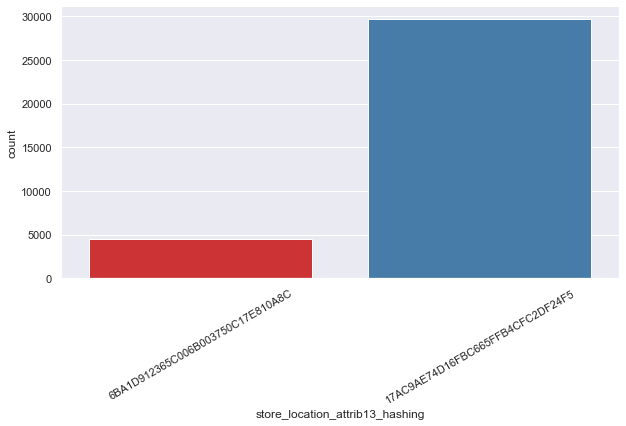

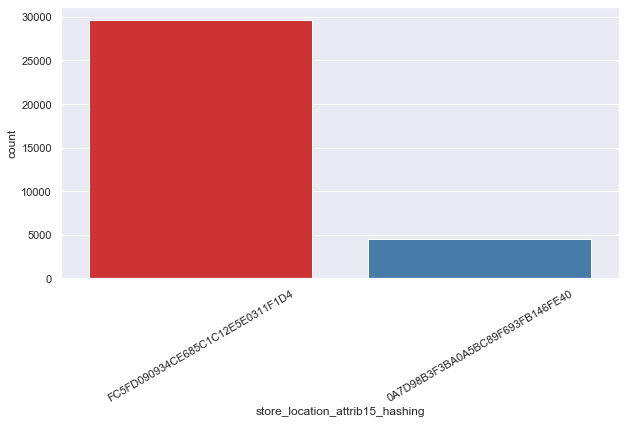

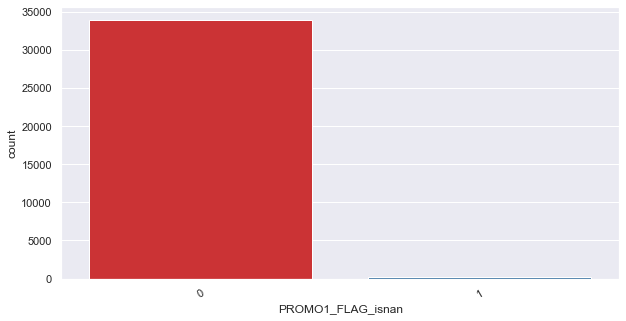

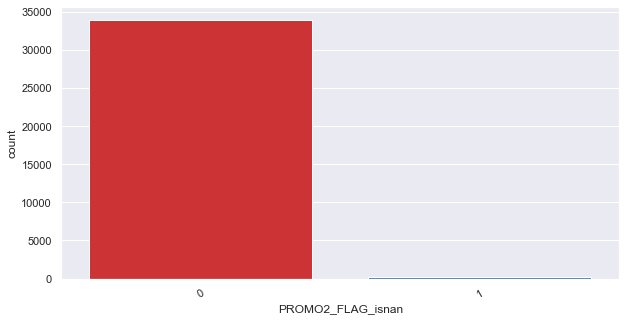

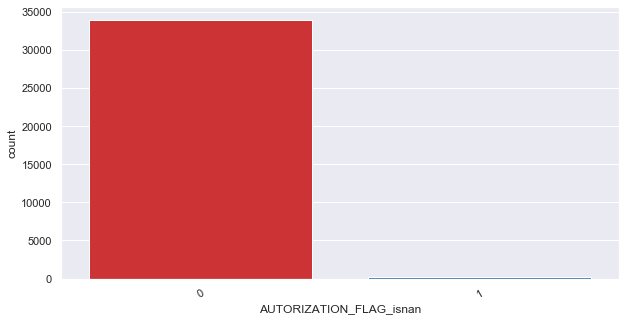

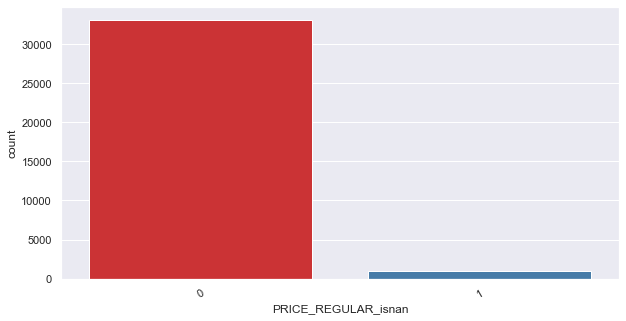

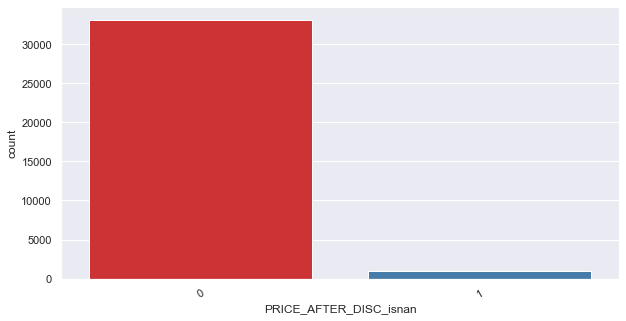

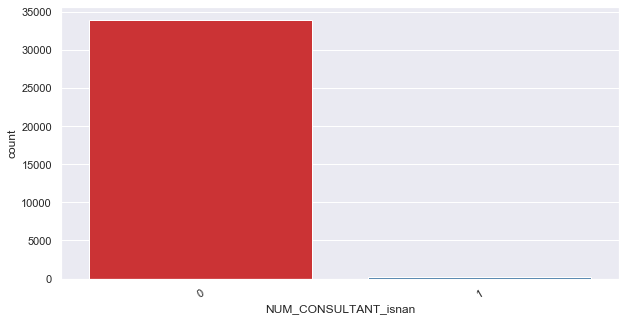

In [12]:
# рассмотрим распределение категориальных признаков
# несмотря на то, что присутствуют разбалансированные категории, в признака с большим числом значений распределение
# более-менее равномерно
# также видим, что мы не имеем каких-то неадекватных аномальных категорий, все имеют логическую обоснованность

for i in categorical:
    if X_train[i].nunique() != 1:
        plt.figure(figsize=(10, 5))
        chart = sns.countplot(data=X_train, x=i, palette='Set1')
        chart.set_xticklabels(chart.get_xticklabels(), rotation=30)
        plt.show()

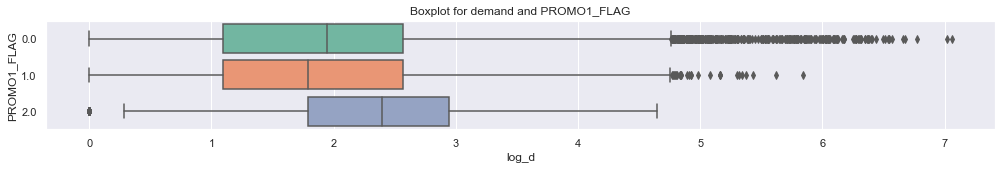

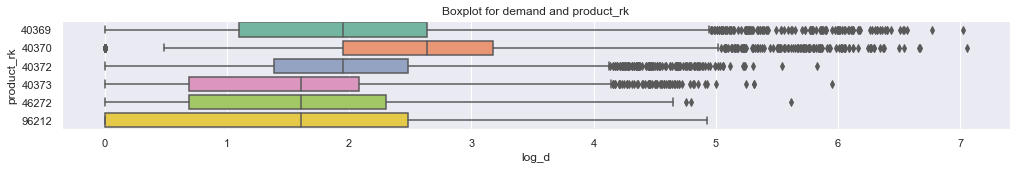

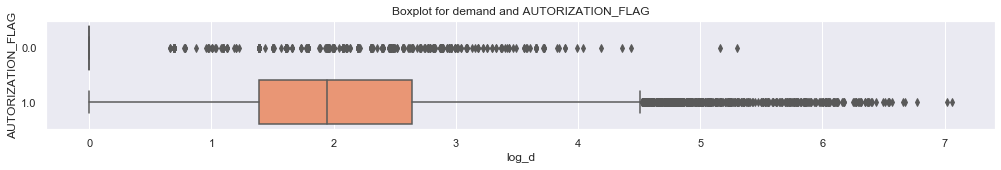

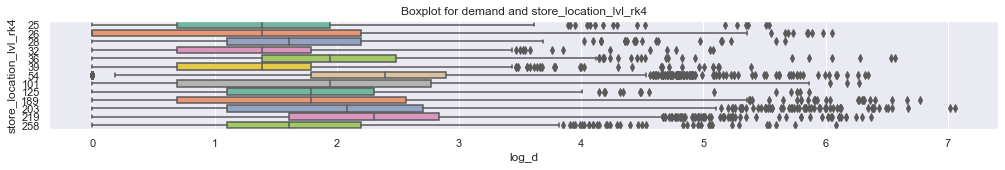

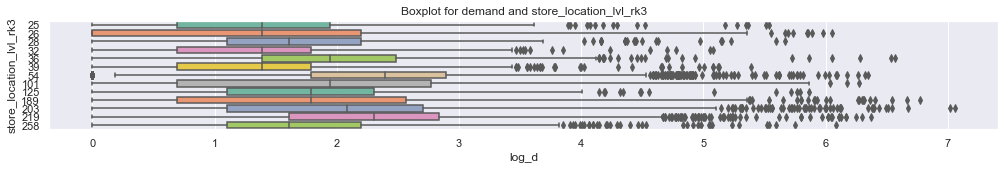

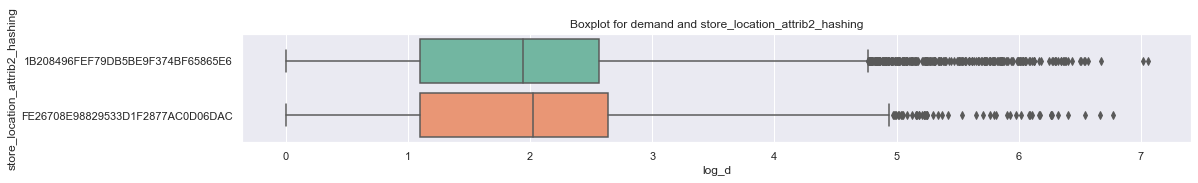

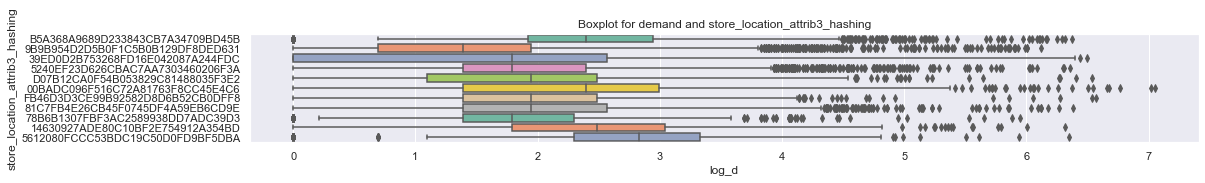

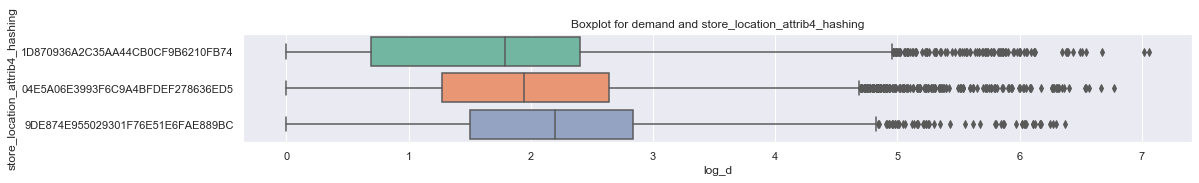

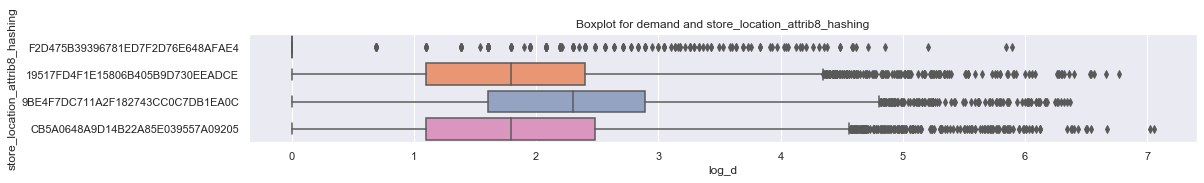

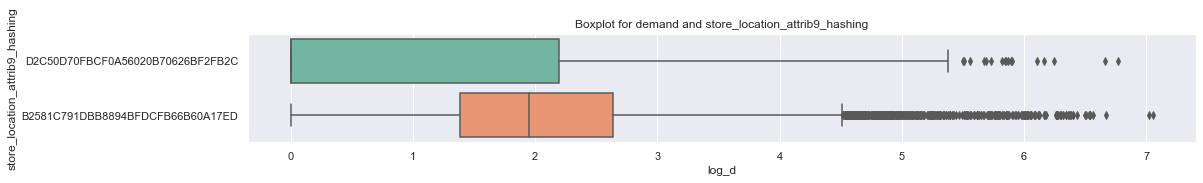

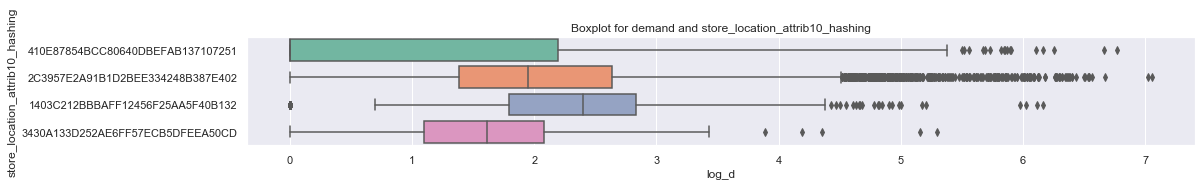

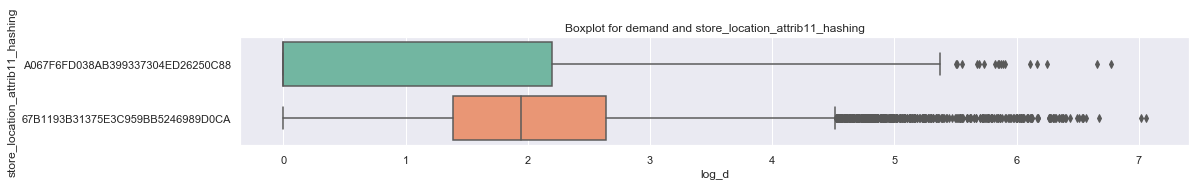

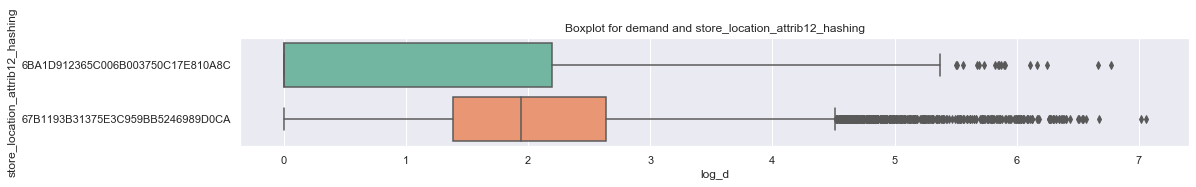

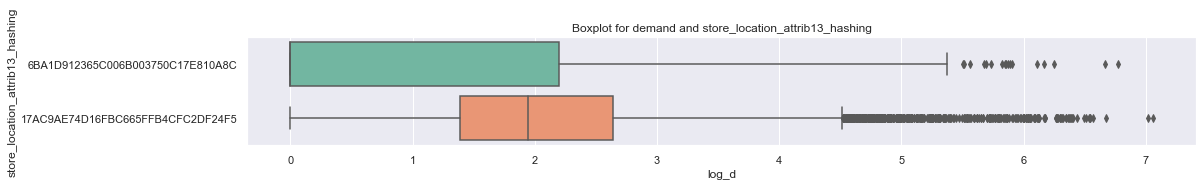

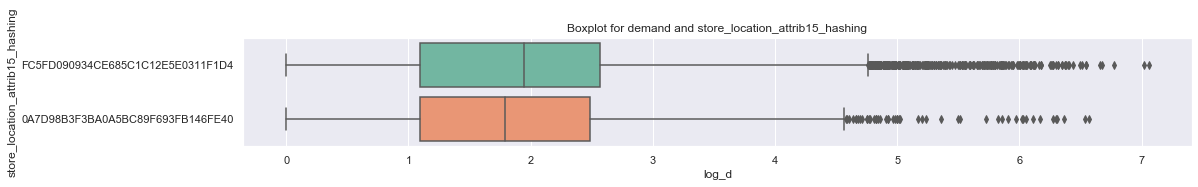

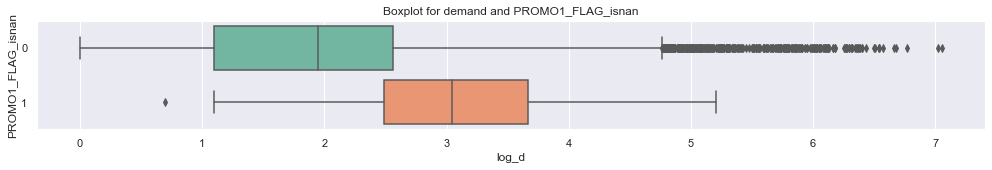

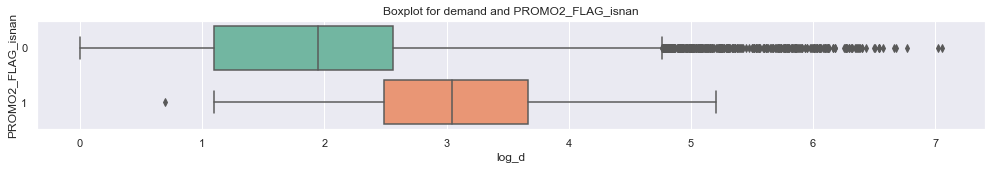

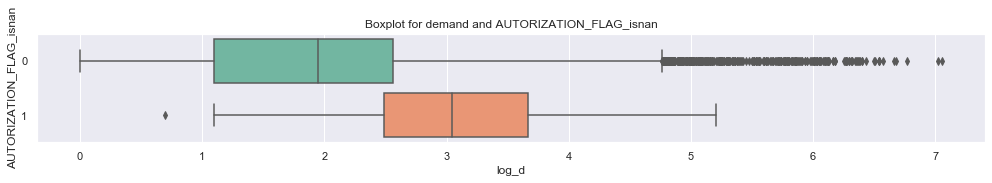

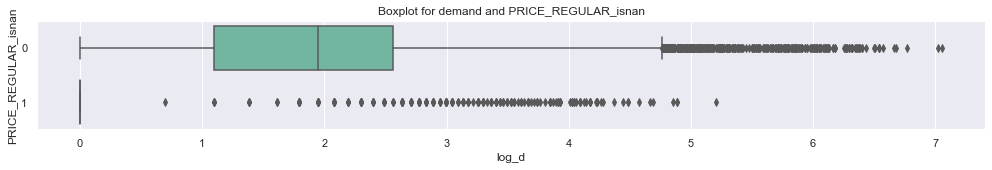

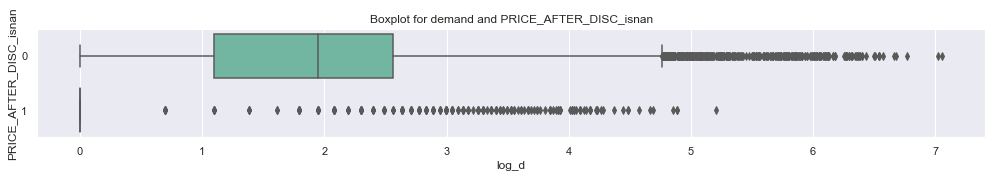

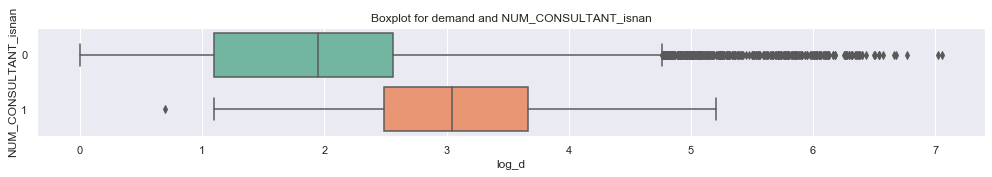

In [13]:
# нарисуем "ящик с усами", показывающий распределение категориальных признаков
# судя по медианному значению, которое различается у разных "ящиков", признаки являются полезными
# для удобства рисуем распределение на логарифмированном demand, чтобы урезать высокие хвосты спроса

X_train['log_d'] = np.log1p(X_train['demand'])
for category in categorical:
    if X_train[category].nunique() != 1:
        plt.figure(figsize=(17,2))
        sns.boxplot(x='log_d', y=category, data=X_train, orient='h', palette="Set2")
        plt.title('Boxplot for demand and ' + category)
        plt.show()

In [14]:
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.metrics import make_scorer



# функция для подсчета score, которая используется в соревновании
def smape(A, F):
    return 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


# кодируем категориальные признаки методом OneHot, а интервальные масштабируем
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

X_train.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# в качестве основной модели используем Bagging Regressor на Решающих деревьях
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', BaggingRegressor(random_state=9))
])

# для примерного осознания качества модели используем 20 фолдов и усредним их score
kf = KFold(n_splits=20, shuffle=True, random_state=42)
score = []
for train_index, test_index in tqdm(kf.split(X_train)):
    x_train, x_test = X_train.loc[train_index, [*categorical, *numeric_features]], \
                        X_train.loc[test_index, [*categorical, *numeric_features]]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipeline.fit(x_train, y_train.values)
    y_pred = pipeline.predict(x_test)
    score.append(smape(y_test, y_pred))
print('Cross validation accuracy: %.3f' % np.array(score).mean())
# делаем предсказание
pipeline.fit(X_train[[*categorical, *numeric_features]], y)
y_pred = pipeline.predict(X_test[[*categorical, *numeric_features]])

20it [01:01,  3.05s/it]


Cross validation accuracy: 61.354


In [407]:
# формурием выходную базу данных и заносим в неё получившееся предсказание

ans = pd.DataFrame(columns=['id', 'predicted'])
ans['predicted'] = pd.Series(y_pred)
ans['id'] = X_test.reset_index().id
ans.to_csv('my_submission.csv', index=False, header=['id', 'predicted'])

### Дополнения:
Помимо проделанной работы в процессе я попробовала:
    - удалять категориальные признаки, в которых содержится только одно значение;
    - объединять редкие категории;
    - использовать вместо OneHot кодирование методом LabelEncoder
Логически такие манипуляции могли бы пойти на пользу модели: снизить вероятность переобучения, например. Но на практике в соревнования такие действия только ухудшали качество, поэтому было принято решение оставить все как есть.